In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.metrics import roc_auc_score
# import riiideducation
# from tqdm import tqdm

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
'''
question == 문제
tag = 해설지(코드)
tags = 비슷한 것 끼리 묶은 것들

train.csv

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. 
The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. 
Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.



questions.csv: metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.



lectures.csv: metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture



example_test_rows.csv Three sample groups of the test set data as it will be delivered by the time-series API. The format is largely the same as train.csv. There are two different columns that mirror what information the AI tutor actually has available at any given time, but with the user interactions grouped together for the sake of API performance rather than strictly showing information for a single user at a time. Some users will appear in the hidden test set that have NOT been presented in the train set, emulating the challenge of quickly adapting to modeling new arrivals to a website.

prior_group_responses (string) provides all of the user_answer entries for previous group in a string representation of a list in the first row of the group. All other rows in each group are null. If you are using Python, you will likely want to call eval on the non-null rows. Some rows may be null, or empty lists.

prior_group_answers_correct (string) provides all the answered_correctly field for previous group, with the same format and caveats as prior_group_responses. Some rows may be null, or empty lists.
'''

In [40]:
train = pd.read_csv('F:/data/riiid-test-answer-prediction/train.csv', nrows=10**4)
test = pd.read_csv("F:/data/riiid-test-answer-prediction/example_test.csv")
lectures = pd.read_csv("F:/data/riiid-test-answer-prediction/lectures.csv")
questions = pd.read_csv("F:/data/riiid-test-answer-prediction/questions.csv")

In [41]:
train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
9995,9995,2868187305,91216,1124,0,775,0,0,18000.0,True
9996,9996,2868272689,91216,810,0,776,0,1,18000.0,True
9997,9997,2868367298,91216,1245,0,777,0,1,17000.0,True
9998,9998,2868439137,91216,711,0,778,3,1,17000.0,True


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int64  
 3   content_id                      1000000 non-null  int64  
 4   content_type_id                 1000000 non-null  int64  
 5   task_container_id               1000000 non-null  int64  
 6   user_answer                     1000000 non-null  int64  
 7   answered_correctly              1000000 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null   float64
 9   prior_question_had_explanation  996184 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 76.3+ MB


In [21]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int64  
 3   content_id                      1000000 non-null  int64  
 4   content_type_id                 1000000 non-null  int64  
 5   task_container_id               1000000 non-null  int64  
 6   user_answer                     1000000 non-null  int64  
 7   answered_correctly              1000000 non-null  int64  
 8   prior_question_elapsed_time     976277 non-null   float64
 9   prior_question_had_explanation  996184 non-null   boolean
dtypes: boolean(1), float64(1), int64(8)
memory usage: 70.6 MB


In [34]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [36]:
lectures['type_of'].unique()

array(['concept', 'solving question', 'intention', 'starter'],
      dtype=object)

In [42]:
train.content_type_id.value_counts()

0    9763
1     237
Name: content_type_id, dtype: int64

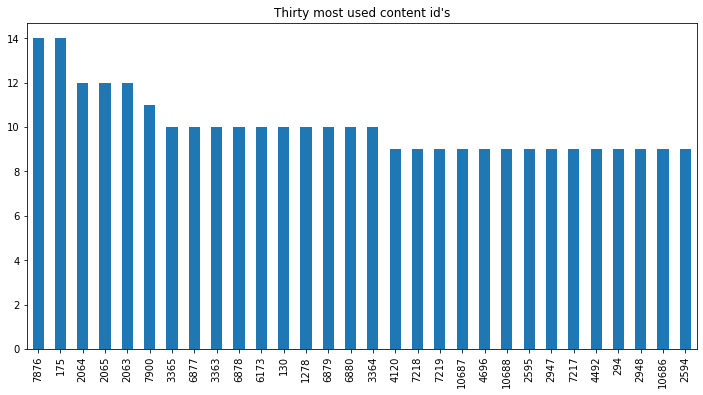

In [57]:
cids = train.content_id.value_counts()[:30]
# figure = 형상 (도화지) 
# figsize = 도화지 크기
fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [63]:
train.task_container_id.nunique()

4890

In [64]:
train.user_answer.value_counts()

 0    2719
 1    2715
 3    2602
 2    1727
-1     237
Name: user_answer, dtype: int64

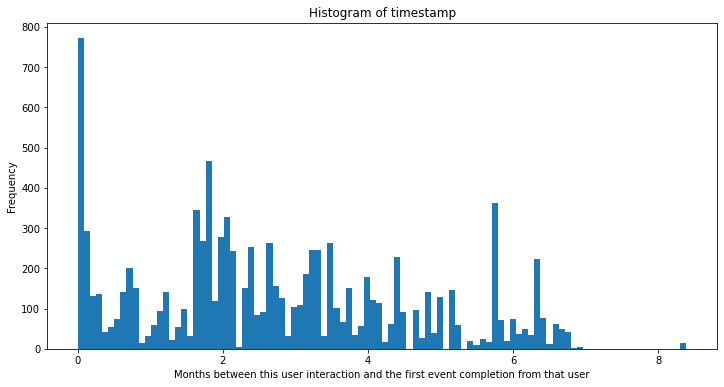

In [67]:
#1 year = 31536000000 ms
# timestamp: (int64) the time in milliseconds between this user interaction 
# and the first event completion from that user.
# timestamp : 산타토익을 이용한 총시간? (누적)
# 산타토익 응시권(기간 30일권 129000원, 60일권 179000원, 90일권 239000원)

ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [68]:
train.user_id.nunique()

21

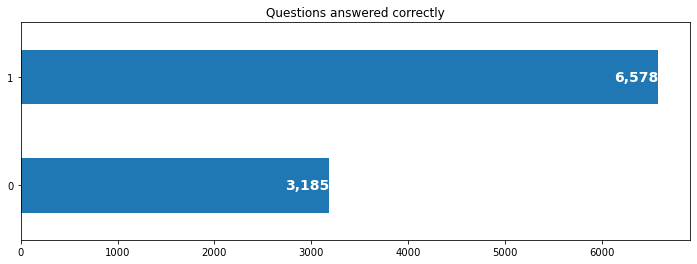

In [69]:
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)

fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()

In [75]:
train[train.answered_correctly != -1].groupby('answered_correctly').size()
pd.pivot()

answered_correctly
0    3185
1    6578
dtype: int64

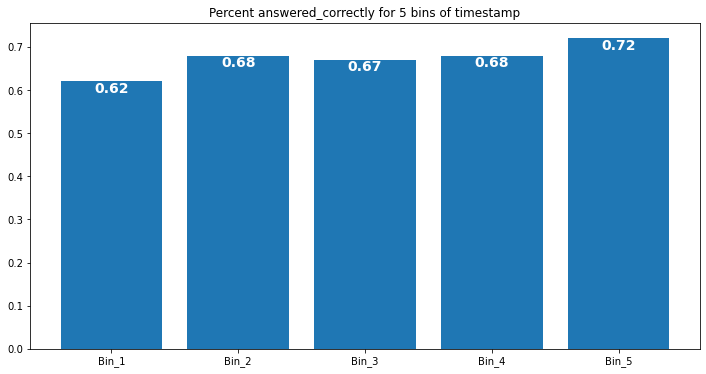

In [70]:
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
train['ts_bin'] = pd.qcut(train['timestamp'], q=5, labels=bin_labels_5)

#make function that can also be used for other fields
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.xticks(rotation=0)
plt.show()

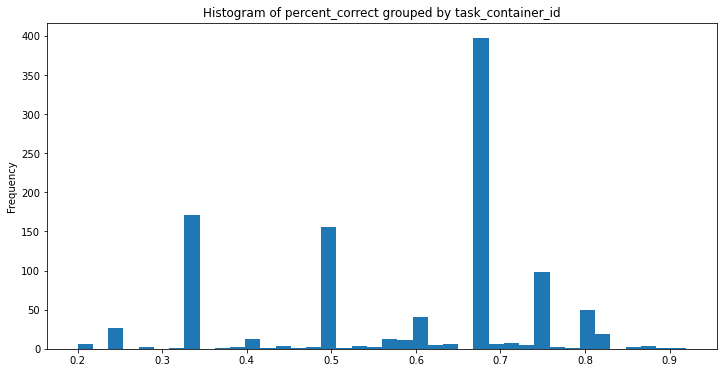

In [76]:
task_id_correct = correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

In [77]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
# 여러개의 함수를 여러 열에 적용 : agg()함수
# 모든열에 여러 함수를 매핑 : group객체.agg([함수1,함수2,함수3,…])
# 각 열마다 다른 함수를 매핑 : group객체.agg({‘열1’: 함수1, ‘열2’:함수2, …})

In [80]:
user_percent[:15]

,Mean,Answers
user_id,,
115,0.695652,46
124,0.233333,30
2746,0.578947,19
5382,0.672000,125
8623,0.642202,109
8701,0.588235,17
12741,0.573585,265
13134,0.706356,1243
24418,0.690275,6283


In [85]:
user_percent.Answers.max()

6283

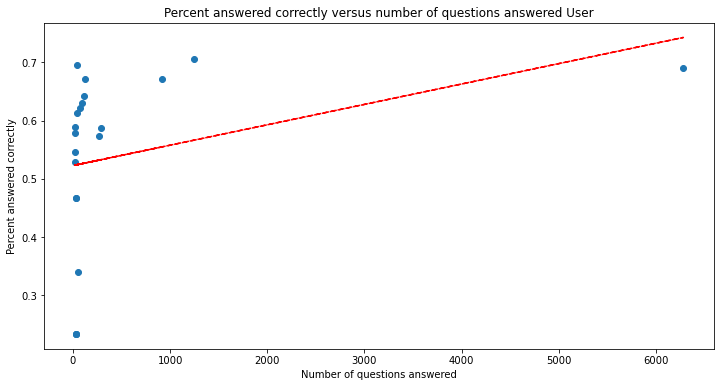

In [91]:
# user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [87]:
content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')

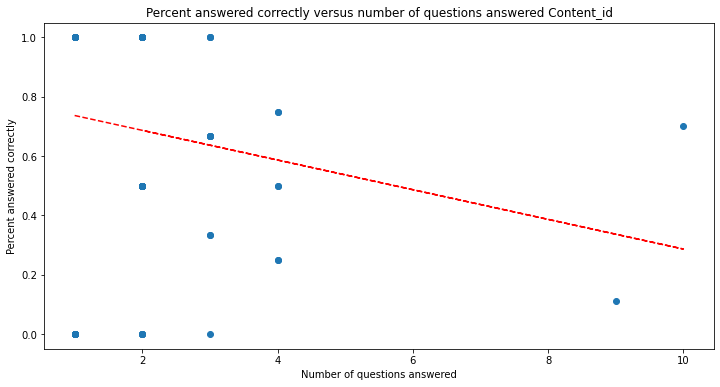

In [88]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()


prior_question_had_explanation
False     412
True     9330
NaN        21
Name: (answered_correctly, count), dtype: int64


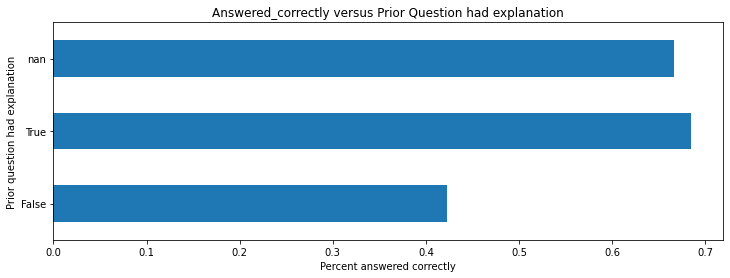

In [82]:
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation") # 문제를 풀든 안 풀든 답지를 봄 1 0
plt.xticks(rotation=0)
plt.show()

In [83]:
pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,3185,22086.292322
1,6578,22083.626904
